In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def groupproject_IRFsimulate(amplitudes, lifetimes, acquisitiontime, irfwidth):
    bg = 10  # number of background counts per second, keep at 10
    if irfwidth == 0:
        irfwidth = 1e-8

    # check that each amplitude has a corresponding lifetime
    if len(amplitudes) != len(lifetimes):
        return

    # create empty vector to store decay data
    puredecay = np.zeros(381)

    # normalise amplitudes, just in case they didn't initially sum to 1
    amplitudes = amplitudes / np.sum(amplitudes)

    # generate a multiexponential decay starting at 1 at t=0
    # using the supplied amplitudes and lifetimes
    for i in range(381):
        t = (1/19) * (i - 1)  # each bin is (1/19) ns, starting at t=0
        for j in range(len(amplitudes)):
            puredecay[i] += amplitudes[j] * np.exp(-t / lifetimes[j])

    # generate the IRF, centred at b
    b = 10 / 19
    w = irfwidth
    irfraw = np.zeros(381)
    for i in range(381):
        t = (i - 20) * (1 / 19)
        irfraw[i] = np.exp(-4 * np.log(2) * (t - b)**2 / (w**2))

    # convolute the IRF and decay and trim to 381 bins
    Iconvol = convolve(puredecay, irfraw, mode='full')[:381]

    # we do our measurements at 2500 counts per second
    # calculate how many fluorescence counts per second this corresponds to
    # i.e. subtract background from total counts
    fluorate = 2500 - bg

    # calculate total number of fluorescence photons counted in measurement
    totalfluorescence = fluorate * acquisitiontime

    # now scale the multiexponential decay so it contains this many counts
    noiseless = totalfluorescence * Iconvol / np.sum(Iconvol)

    # and add on 'bg' counts per second spread evenly across all bins
    noiseless = noiseless + (bg * acquisitiontime / 381)

    # finally add Poisson noise to each bin
    noisydecay = np.random.poisson(noiseless)

    # and tidy up output with a time axis
    output = np.zeros((381,2))
    for i in range(381):
        output[i, 0] = (i - 1) * (1 / 19)
        output[i, 1] = noisydecay[i]

    return output


In [5]:
from scipy import stats
def sim_decay_photon_count_multiple(sim_param, Tau, N, n_decay):
    # n_decay is the number of decay to simulate

    Display = 0

    # IRF parameters
    t0 = sim_param[0]    # offset in ns
    s = sim_param[1]    # standard deviation of Gaussian function in ns

    # Acquisition parameters
    n = sim_param[2]       # number of bits coding the TAC n = 8 --> 256 bins
    T = sim_param[3]      # Acquisition window 0-T in ns
    R = sim_param[4]      # Repetition rate of the laser in MHz
    Ap = sim_param[5]      # Afterpulsing in # --> background in TCSPC

    # Generating the arrival times
    if Tau > 0:
        #generate uniform random distribution between 0 and 1
        u_f = np.random.rand(N, n_decay)
        #arrival time in exponential distribution
        #1/(1-u_f) is inverse transform mapping
        t_f = Tau * np.log(1. / (1 - u_f))
    else:
        t_f = np.zeros((N, n_decay))

    if t0 <= 0 or s <= 0:
        t_irf = np.zeros((N, n_decay))
    else:
        u_irf = np.random.rand(N, n_decay)
        t_irf = t0 - s * np.sqrt(2) * stats.norm.ppf(2 * u_irf - 1)

    t_tot = t_f + t_irf

    # Incomplete decays
    T_rep = 1000 / R
    t_tot = np.mod(t_tot, T_rep)

    # Afterpulsing background
    N_bg = np.ceil(Ap / 100 * N)
    t_Ap = T * np.random.rand(int(N_bg), n_decay)
    t_tot = np.vstack((t_tot, t_Ap))

    # Histogramming
    t = np.linspace(0, T, 2 ** n + 1)
    t = t[:-1]
    phot_number = np.histogram(t_tot, bins=np.concatenate((t, [t[-1] + t[1] - t[0]])))[0]

    if Display == 1:
        # Displaying
        plt.figure()
        plt.semilogy(t, phot_number)
        plt.xlabel('Time (ns)')
        plt.ylabel('Photon counts')
        plt.title('N = {} photons, Tau = {} ns'.format(N, Tau))

        plt.figure()
        plt.plot(t, phot_number)
        plt.xlabel('Time (ns)')
        plt.ylabel('Photon counts')
        plt.title('N = {} photons, Tau = {} ns'.format(N, Tau))

    return t, phot_number

In [9]:
# Change acquisition parameters --------------------
R = 80      #Repetition rate of the laser in MHz units
T = 12.5    # Acquisition window 0-T in ns units
n = 8       # number of bits coding the TAC n = 8 --> 256 bins
Ap = 5      # Afterpulsing in # --> background in TCSPC

# Change parameters for IRF-----------------------------
t0 = 1.5;    # offset in ns units
s = 0.0001;    # standard deviation of Gaussian function in ns units
N_irf = 1e8; # MAXIMUM 10^8! (150,000 for 256 bins to get close to 16 bit histograms)
N = 5000     # no. of photons
n_decay = 1024 #n_decay is the number of decay to simulate
Tau = 5      #lifetime /ns
sim_param = [t0, s, n, T, R, Ap]
t,n_photon = sim_decay_photon_count_multiple(sim_param, Tau, N, n_decay)

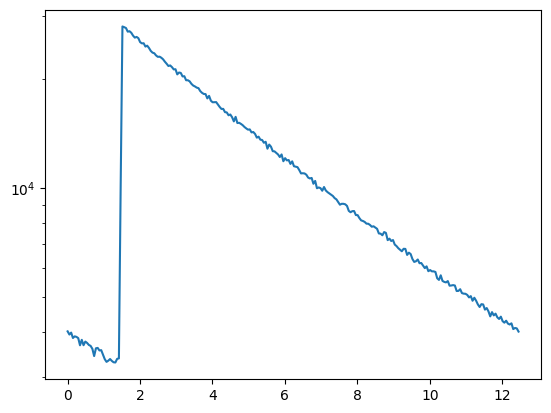

In [11]:
plt.plot(t,n_photon)
plt.yscale('log')

In [13]:
np.arange(0,381*(1+1/19),1/19)

array([0.00000000e+00, 5.26315789e-02, 1.05263158e-01, ...,
       4.00894737e+02, 4.00947368e+02, 4.01000000e+02])

In [3]:
data=groupproject_IRFsimulate([0.8,0.2],[0.4,3],600,0)

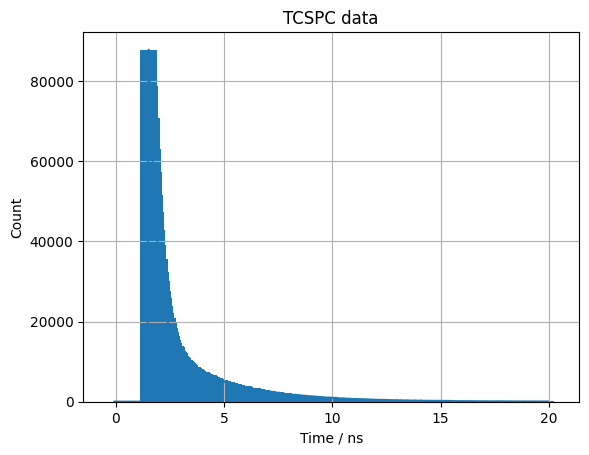

In [10]:
#xpoints = np.linspace(0,1,100)

plt.figure()
plt.title(r'TCSPC data')
plt.xlabel(r'Time / ns')
plt.ylabel(r'Count')
plt.grid()

plt.bar(data[:, 0],data[:, 1])
#plt.plot(data[:, 0],data[:, 1])
#plt.legend(loc="best")